In [1]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
np.seterr(under = 'ignore')
from time import time
from munch import munchify

Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


In [2]:
## multi T mutli U data
from FKMC.import_funcs import get_data_funcmap, mean_over_MCMC, IPRandDOS, extract
def load_local(path): 
    p = Path(path)
    return get_data_funcmap(p,
                functions = [IPRandDOS(E_bins = np.linspace(-20, 20, 10000 + 1)), 
                             mean_over_MCMC('Mf_moments'),
                            ],
                structure_names = ('repeats',),
                structure_dims = (None,),
               )

logger = logging.getLogger('FKMC.import_funcs')
logger.setLevel(logging.INFO) 

raw_data = dict()

In [3]:
from multiprocessing import Pool
runs = [
    f"/workspace/tch14/local_run_data/run_5_T=1.5",
    f"/workspace/tch14/local_run_data/run_8_T=1.5_U=5",
    f"/workspace/tch14/local_run_data/run_9_T=2.5_U=5",
]

#doesn't work I think because the returned object is too big
#with Pool(6) as p:
#    raw_data_list = p.map(load_local, runs)

raw_data_list = map(load_local, runs)

for i, path, d in zip(count(), runs, raw_data_list):
    raw_data[i] = munchify(d)
    print(f"path: {path}, structure_dims: {raw_data[i].structure_dims}")

print('done!')

looking in /workspace/tch14/local_run_data/run_5_T=1.5


0 16 32 48 64 80 96 112 128 144 160 176 192 208 224 240 256 272 288 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576 592 608 624 640 656 672 688 704 720 736 752 768 784 800 816 

looking in /workspace/tch14/local_run_data/run_8_T=1.5_U=5


832 path: /workspace/tch14/local_run_data/run_5_T=1.5, structure_dims: (833,)
0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 

looking in /workspace/tch14/local_run_data/run_9_T=2.5_U=5


path: /workspace/tch14/local_run_data/run_8_T=1.5_U=5, structure_dims: (100,)
0 3 6 9 12 15 18 21 24 27 30 33 36 39 42 45 48 51 54 57 60 63 66 69 72 75 78 81 84 87 90 93 96 99 102 105 108 111 114 117 120 123 126 129 132 135 138 141 144 147 150 153 156 159 162 165 168 path: /workspace/tch14/local_run_data/run_9_T=2.5_U=5, structure_dims: (169,)
done!


In [3]:
#with open(f'/workspace/tch14/pickled_data/local_runs_processed.pickle', 'wb') as f:
#    # Pickle the 'data' dictionary using the highest protocol available.
#    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
#    print('Pickling Successful')

In [4]:
#with open(f'/workspace/tch14/pickled_data/local_runs_processed.pickle', 'rb') as file: 
#    data = pickle.load(file)
#    print(data.keys())

In [4]:
from munch import munchify
from FKMC.general import smooth, spread
from scipy.stats import sem

def prepare_data(o):
    #print(f"Keys available in data: {o.keys()}")

    #print("Hamiltionian params for the data:")
    #print(", ".join(f"{k} = {v}" for k,v in o.parameters.items()))
    #print('\n')

    #print("Simulation params for the data:")
    #print(o.MCMC_params)

    #print('\nShape hint for o.IPR')
    #print(o.hints.DOS)
    #print(o.DOS.shape)

    o.energy_histogram_bins = o.E_bins

    #pluck out particular Ns and starting states
    #Nmask = (o.Ns % 2 == 0)
    #o.Ns = o.Ns[Nmask]
    #print(o.Ns, Nmask)
    #for name in ['DOS', 'dDOS', 'IPR', 'dIPR', 'Mf_moments']:
    #    o[name] = o[name][Nmask]
        #o[name] = o[name][:, :, [0,1,2]] #get particular starting states

    mean_axis = (1,) #mean out the repeat and starting states axes
    sem_axis = 1
    print(f'Taking mean over axes {mean_axis} which are {np.array(o.hints.DOS)[mean_axis,]} with size {np.array(o.DOS.shape)[mean_axis,]}')

    #use the indepedant repeats to estimate the errors
    o.DOS, o.dDOS = o.DOS.mean(axis = mean_axis), sem(o.DOS, axis = sem_axis)
    o.IPR, o.dIPR = o.IPR.mean(axis = mean_axis), sem(o.IPR, axis = sem_axis)

    #use binning over the mcmc steps to estimate the errors
    #o.DOS, o.dDOS = np.nanmean(o.DOS, axis = axis), np.nanmean(o.dDOS, axis = axis)
    #o.IPR, o.dIPR = np.nanmean(o.IPR, axis = axis), np.nanmean(o.dIPR, axis = axis)

    print('\nShape of o.DOS after mean')
    print(o.DOS.shape)
    o.hints.DOS = np.delete(o.hints.DOS, mean_axis)
    print(o.hints.DOS)

    #('Ns', 'Ts', 'energy index')

    #smooth them
    for i, N in zip(count(), o.Ns):
        scale = 0.1
        o.DOS[i] = smooth(o.DOS[i], scale)
        o.IPR[i] = smooth(o.IPR[i], scale)

        o.dDOS[i] = smooth(o.dDOS[i], scale)
        o.dIPR[i] = smooth(o.dIPR[i], scale)
    return o
    
data = dict()    
for name, o in raw_data.items():
    o = munchify(o)
    print(f'steps per file = {o.MCMC_params.N_steps}, thin = {o.MCMC_params.thin}')
    print(f'Doing {name}, T={1 / o.parameters.beta}')
    print(f'Ns = {o.Ns}')
    data[name] = prepare_data(o)
    
with open(f'/workspace/tch14/pickled_data/local_runs_processed_smoothed_june2.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
    print('Pickling Successful')    

print('Done')

steps per file = 500, thin = 10
Doing 0, T=1.5
Ns = [ 40  60  70  80 100 120 150 180 220 270]
Taking mean over axes (1,) which are ['repeats'] with size [833]

Shape of o.DOS after mean
(10, 10000)
['Ns' 'energy index']
steps per file = 500, thin = 10
Doing 1, T=1.5
Ns = [ 40  60  70  80 100 120 150 180 220 270]
Taking mean over axes (1,) which are ['repeats'] with size [100]

Shape of o.DOS after mean
(10, 10000)
['Ns' 'energy index']
steps per file = 500, thin = 10
Doing 2, T=2.5
Ns = [ 40  60  70  80 100 120 150 180 220 270]
Taking mean over axes (1,) which are ['repeats'] with size [169]

Shape of o.DOS after mean
(10, 10000)
['Ns' 'energy index']
Pickling Successful
Done


In [36]:
for name, o in data.items():
    o = munchify(o)
    print(f'steps per file = {o.MCMC_params.N_steps}, thin = {o.MCMC_params.thin}')
    
500 * 800

steps per file = 200, thin = 10
steps per file = 500, thin = 10
steps per file = 500, thin = 10
steps per file = 500, thin = 10
steps per file = 500, thin = 10
steps per file = 500, thin = 10


400000

In [5]:
with open(f'/workspace/tch14/pickled_data/local_runs_processed_smoothed_june2.pickle', 'rb') as file: 
    data = pickle.load(file)
    print(data.keys())

dict_keys([0, 1, 2])


In [ ]:
single.hints.Mf_moments

In [21]:
data[1].hints.DOS, data[1].DOS.shape, data[1].E_bins.shape

(array(['Ns', 'energy index'], dtype='<U12'), (10, 10000), (10001,))

Text(0.5, 0.98, 'T = 1.5 U = 10')

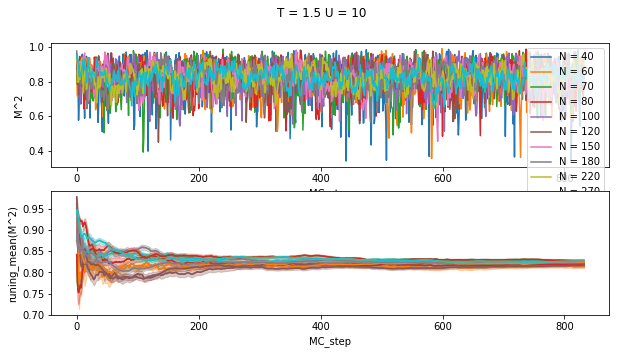

In [7]:
from FKMC.general import running_mean, running_sem
from FKMC.plotting import spread



def plot_Mf_mean(single):
    f, (ax,axcum) = plt.subplots(2,1, figsize = (10,5))
    for i, N in zip(count(), single.Ns):
        ax.plot(single.Mf_moments[i, :, 2], label = f'N = {N}')

        axcum.plot(running_mean(single.Mf_moments[i, :, 2]), label = f'N = {N}')
        Y = running_mean(single.Mf_moments[i, :, 2])
        dY = running_sem(single.Mf_moments[i, :, 2])
        X = np.arange(len(Y))

        spread(axcum, X, Y, dY, alpha = 0.3)

    ax.set(xlabel = "MC_step", ylabel = 'M^2')
    axcum.set(xlabel = "MC_step", ylabel = 'runing_mean(M^2)')
    ax.legend()
    
    return f, (ax, axcum)
  
i = 0
f, axes = plot_Mf_mean(data[i])
f.suptitle(f'T = {1 / data[i].parameters.beta} U = {data[i].parameters.U}')

Text(0.5, 0.98, 'T = 1.5 U = 5')

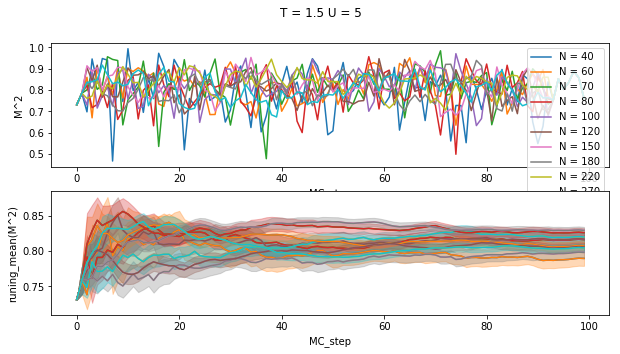

In [8]:
i = 1
f, axes = plot_Mf_mean(data[i])
f.suptitle(f'T = {1 / data[i].parameters.beta} U = {data[i].parameters.U}')

Text(0.5, 0.98, 'T = 2.5 U = 5')

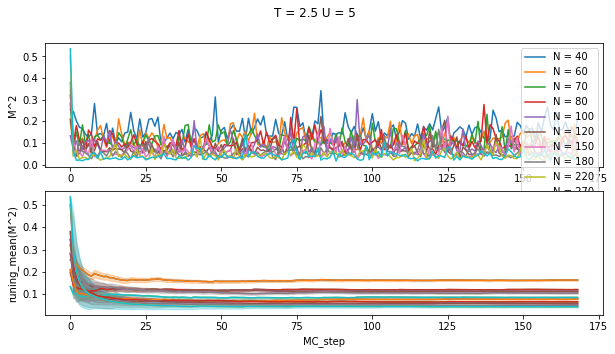

In [9]:
i = 2
f, axes = plot_Mf_mean(data[i])
f.suptitle(f'T = {1 / data[i].parameters.beta} U = {data[i].parameters.U}')

Text(0.5, 0.98, 'T = 1.5, J = 5, U = 5, M**2 = 0.81')

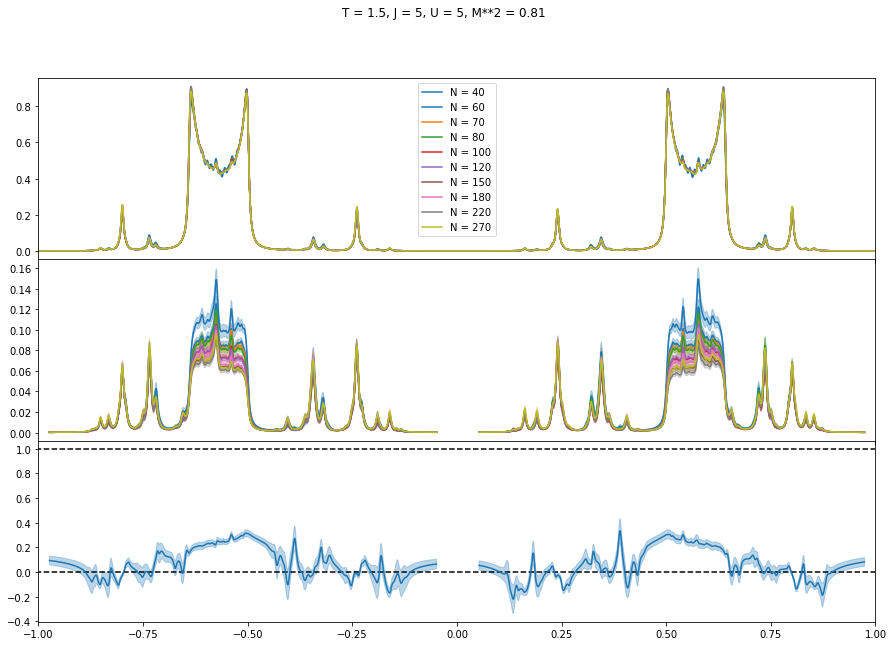

In [21]:
from FKMC.plotting import plot_scaling_dimension
o = data[1]

f, axes = plot_scaling_dimension(
                       original_data = o,
                       filter_indices = None,
                       spread_IPR = True,
                       cutoffs = [0,],
                       DOS_cutoff = 0.001)

axes[0].legend()
axes[0].set(xlim = (-1, 1))
f.suptitle(f'T = {1 / o.parameters.beta}, J = {o.parameters.J}, U = {o.parameters.U}, M**2 = {o.Mf_moments[-1, :, 2].mean():.2f}')

Text(0.5, 0.98, 'T = 1.5, J = 5, U = 5, M**2 = 0.81')

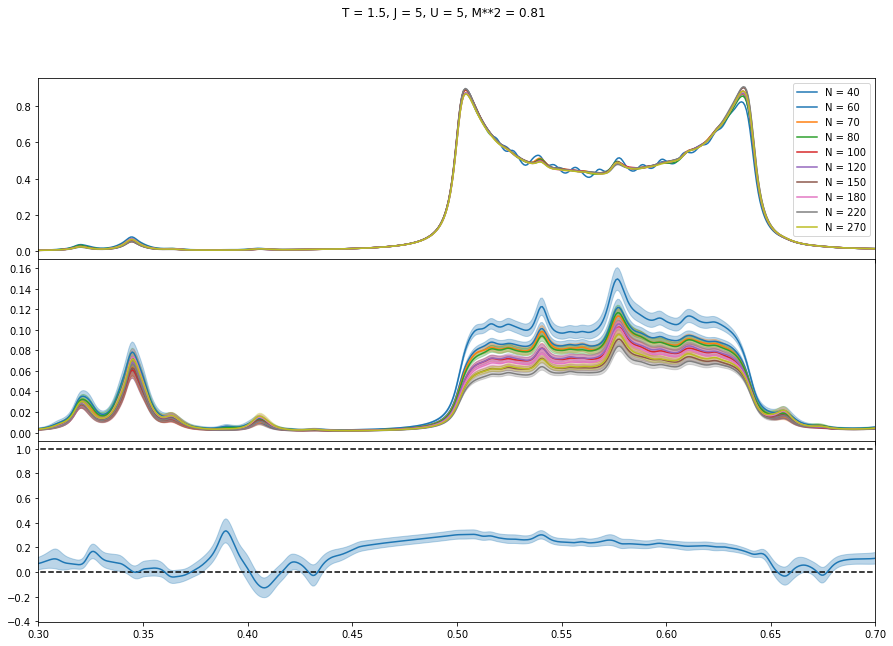

In [12]:
from FKMC.plotting import plot_scaling_dimension
o = data[1]

f, axes = plot_scaling_dimension(
                       original_data = o,
                       filter_indices = None,
                       spread_IPR = True,
                       cutoffs = [0,],
                       DOS_cutoff = 0.001)

axes[0].legend()
axes[0].set(xlim = (0.3, 0.7))
f.suptitle(f'T = {1 / o.parameters.beta}, J = {o.parameters.J}, U = {o.parameters.U}, M**2 = {o.Mf_moments[-1, :, 2].mean():.2f}')

Text(0.5, 0.98, 'T = 2.5, J = 5, U = 5, M**2 = 0.04')

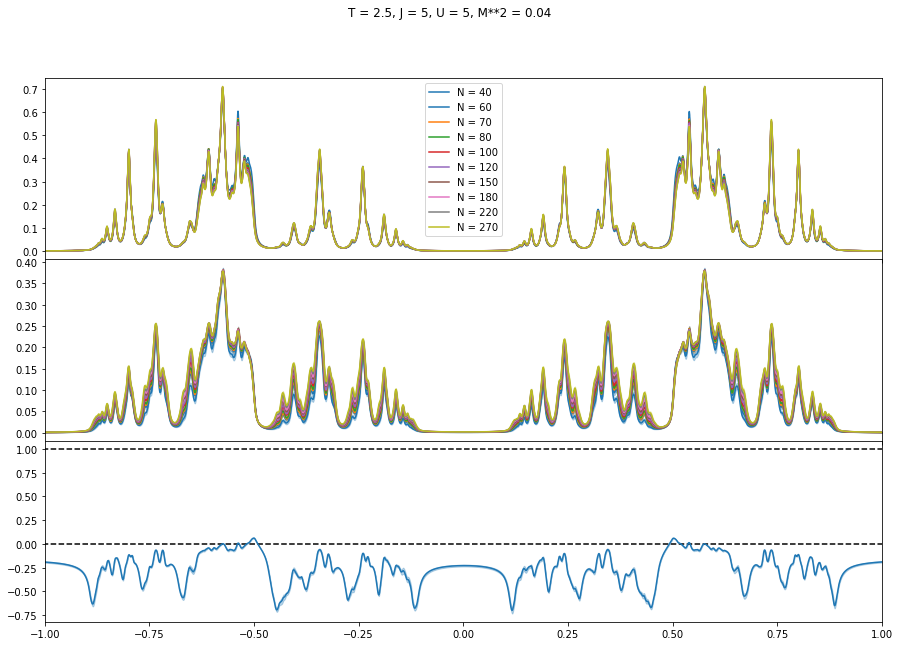

In [15]:
from FKMC.plotting import plot_scaling_dimension
o = data[2]

f, axes = plot_scaling_dimension(
                       original_data = o,
                       filter_indices = None,
                       spread_IPR = True,
                       cutoffs = [0,],
                       DOS_cutoff = 0.001)

axes[0].legend()
axes[0].set(xlim = (-1, 1))
f.suptitle(f'T = {1 / o.parameters.beta}, J = {o.parameters.J}, U = {o.parameters.U}, M**2 = {o.Mf_moments[-1, :, 2].mean():.2f}')

Text(0.5, 0.98, 'T = 2.5, J = 5, U = 5, M**2 = 0.04')

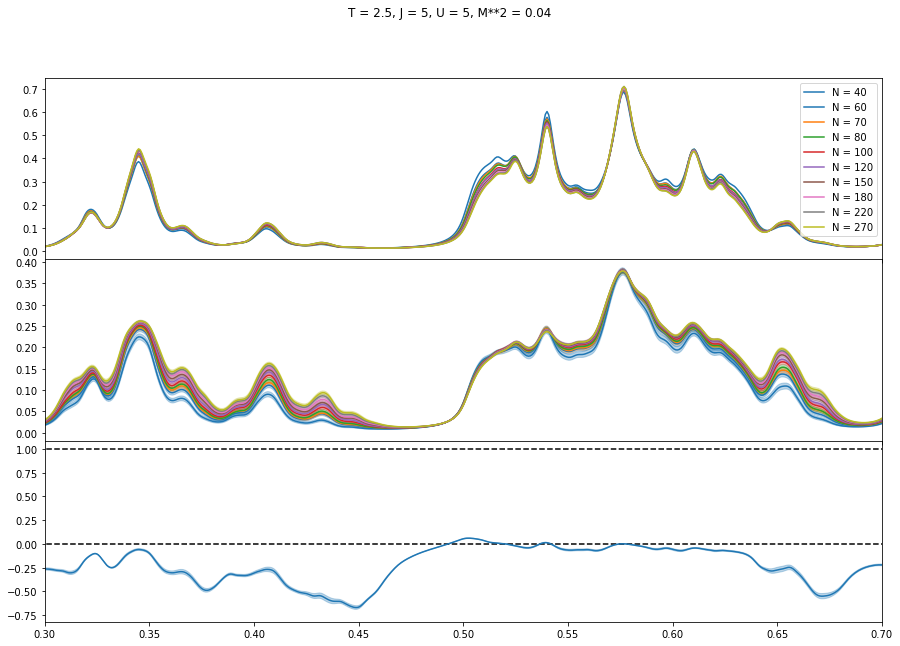

In [20]:
from FKMC.plotting import plot_scaling_dimension
o = data[2]

f, axes = plot_scaling_dimension(
                       original_data = o,
                       filter_indices = None,
                       spread_IPR = True,
                       cutoffs = [0,],
                       DOS_cutoff = 0.001)

axes[0].legend()
axes[0].set(xlim = (0.3, 0.7))
f.suptitle(f'T = {1 / o.parameters.beta}, J = {o.parameters.J}, U = {o.parameters.U}, M**2 = {o.Mf_moments[-1, :, 2].mean():.2f}')

Text(0.5, 0.98, 'J = 5, U = 5')

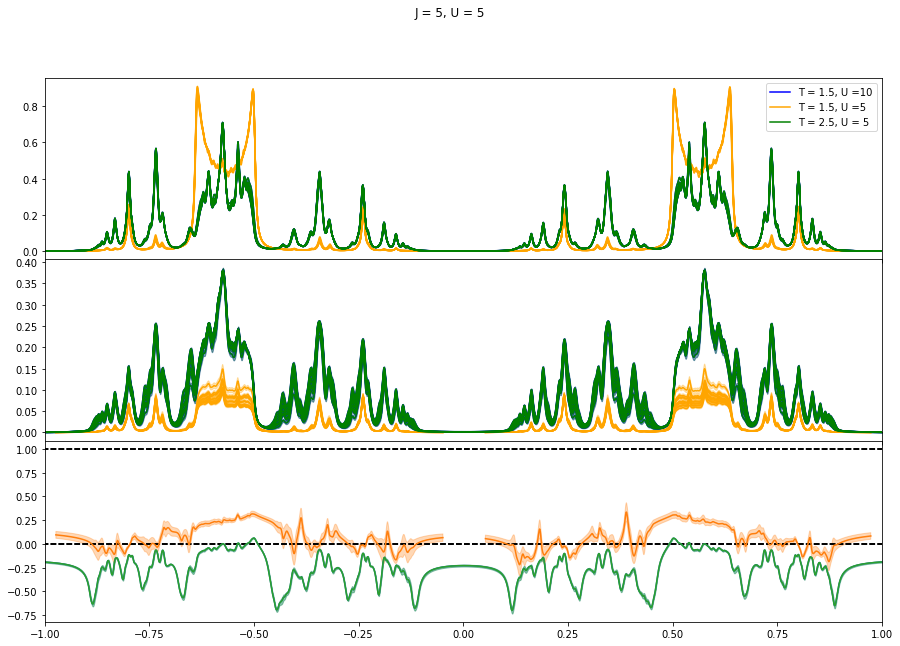

In [19]:
from FKMC.plotting import plot_scaling_dimension

o = data[2]

f, axes = plot_scaling_dimension(
                       original_data = o,
                       filter_indices = None,
                       spread_IPR = True,
                       cutoffs = [0,],
                       DOS_cutoff = 0.001,
                       #Nmask = [-1],
                      colors = ['b',] * 10,
)

o = data[1]

plot_scaling_dimension(
                       original_data = o,
                       filter_indices = None,
                       spread_IPR = True,
                       cutoffs = [0,],
                       DOS_cutoff = 0.001,
                       #Nmask = [-1],
                       axes = axes,
                        colors = ['orange',] * 10,
)

o = data[2]

plot_scaling_dimension(
                       original_data = o,
                       filter_indices = None,
                       spread_IPR = True,
                       cutoffs = [0,],
                       DOS_cutoff = 0.001,
                       #Nmask = [-1],
                       axes = axes,
                       colors = ['g',] * 10,
)


from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='b', label='T = 1.5, U =10'),
    Line2D([0], [0], color='orange', label='T = 1.5, U =5'),
    Line2D([0], [0], color='g', label='T = 2.5, U = 5'),
                  ]
axes[0].legend(handles=legend_elements)

axes[0].set(xlim = (-1, 1))
f.suptitle(f'J = {o.parameters.J}, U = {o.parameters.U}')